# ML Explainer - How does PCA work

Pieter Overdevest  
2024-03-12

For suggestions/questions regarding this notebook, please contact
[Pieter Overdevest](https://www.linkedin.com/in/pieteroverdevest/)
(pieter@innovatewithdata.nl).

### How to work with this Jupyter Notebook yourself?

- Get a copy of the repository ('repo') [machine-learning-with-python-explainers](https://github.com/EAISI/machine-learning-with-python-explainers) from EAISI's GitHub site. This can be done by either cloning the repo or simply downloading the zip-file. Both options are explained in this Youtube video by [Coderama](https://www.youtube.com/watch?v=EhxPBMQFCaI).

- Copy the folder 'ml-explainers\\' located in the folder 'example-solutions\\' to your own project folder.

#### Aim
To explain how PCA works with various data sets, incl. Iris, USArrests, Ames Housing, and two synthetic data sets, to demonstrate the opportunities and limitations of PCA.

#### Initialization

We start by importing a few packages,

In [1]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from numpy.random import rand

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns
import plotly.express as px
import random
import warnings

# This helps to silence a 'FutureWarning' from the Altair library, specifically regarding
# the use of the convert_dtype parameter in the apply() method.
warnings.simplefilter(action='ignore', category=FutureWarning)

random.seed(10)

# Setting Pandas options.
pd.set_option("display.max_rows", 50) # How to display all rows from data frame using pandas. Setting value to None to show all rows.
pd.set_option("display.max_columns", None)
pd.set_option("display.max_info_columns", 100)
pd.set_option("display.max_info_rows", 1000000)
pd.set_option("display.precision", 2)
#pd.set_option("styler.format.precision", 2)

#### Get the data

With this notebook you can test PCA on four data sources:
1. **Iris data** - A commonly used simple dataset to demonstrate classification models
2. **USArrests data** - This set is used in ISLR to explain PCA, see chapter 12.2 (Ed. 2)
3. **Ames Housing data** - The Ames Housing data set. Note, we make use of a pickle file in the data folder in /example-solutions/ames-housing-pieter/.
3. **Dummy data I** - To demonstrate the effect of various levels of correlations between features in a linear dataset
4. **Dummy data II** - This non-linear dataset is also used in ML Explainer `umap-t-sne`. Here, we investige what we can (not) do with PCA.

> **The same analysis can be done with any of these five data sets, just select the one you want below by removing the '#'.**

In [2]:
#c_dataset = "iris"
#c_dataset = "usarrests"
#c_dataset = "ames housing"
c_dataset = "dummy_i"
#c_dataset = "dummy_ii"

##### Iris dataset

The Iris dataset is a simple dataset available through the `datasets` packages. It contains 150 observations and five features. One variable describes the variety the observation belongs to, and is used as the outcome (target) variable in a classification model. The data contains 50 observations per variety. The other four variables describe the geometry
of the flower (petal length, petal width, sepal length, and sepal width).

In [3]:
if c_dataset == "iris":

    # The 'data_original' object is a collection of data objects, that we each assign to other objects.
    data_original   = datasets.load_iris()

    # Assign the feature names (l_X_names), the predictor data (df_X), and the target variable (ps_y)
    # to individual objects. Object ps_y is converted to a Pandas Series to have it of the same type as in
    # case of USArrests data.
    l_X_names = list(data_original.feature_names)
    m_X       = data_original.data
    df_X      = pd.DataFrame(m_X, columns = l_X_names)
    ps_y      = pd.Series([data_original.target_names[i] for i in data_original.target])

##### USArrests dataset

The USArrests dataset consists of five features - ‘Unnamed: 0’ (state name), ‘Murder’, ‘Assault’, ‘UrbanPop’, and ‘Rape’. Each row represents
the data for a state, there are 50 rows for 50 states.

In [4]:
if c_dataset == "usarrests":

    data_original   = pd.read_csv("https://raw.githubusercontent.com/JWarmenhoven/ISLR-python/master/Notebooks/Data/USArrests.csv")

    # Assign the predictor data (df_X), the feature names (l_X_names) and the target variable (ps_y)
    # to individual objects.
    df_X      = data_original.drop('Unnamed: 0', axis = 1)
    m_X       = df_X.values
    l_X_names = list(df_X.columns.values)
    ps_y      = data_original['Unnamed: 0']

##### Ames Housing data

The Ames Housing dataset consists of 39 numerical features. Each row represents the data for a sold house, there are 2930 rows.

In [5]:
if c_dataset == "ames housing":

    import pickle
    
    with open('../example-solutions/ames-housing-pieter/data/dc-ames-housing-pieter-exercise-1-2-3.pkl', 'rb') as pickle_file:
        dc_exercise_1_2_3 = pickle.load(pickle_file)

    df_reduced     = dc_exercise_1_2_3['df_reduced']
    l_df_num_names = dc_exercise_1_2_3['l_df_num_names']

    # Assign the predictor data (df_X), the feature names (l_X_names) and the target variable (ps_y)
    # to individual objects.
    l_X_names = [x for x in l_df_num_names if x != 'SalePrice']
    df_X      = df_reduced[l_X_names].copy()
    m_X       = df_X.values
    ps_y      = pd.Series(['dummy'] * df_X.shape[0])


##### Dummy dataset I

We create a synthetic linear data set as this allows us to choose the correlation between features. This way we can investigate their influence on the PCA.

In [6]:
if c_dataset == "dummy_i":

    # Define the predictor data (df_X), the feature names (l_X_names) and the target variable (ps_y)
    # to individual objects.
    v_x1 = 20 * rand(150)
    v_x2 = v_x1 + 3 * rand(150)  # x1 and x2 are highly   correlated
    v_x3 = v_x1 + 50 * rand(150) # x1 and x3 are somewhat correlated
    v_x4 = 20 * rand(150)        # x1 and x2 are not      correlated

    m_X       = np.array([v_x1, v_x2, v_x3, v_x4]).transpose()
    l_X_names = ['x1', 'x2', 'x3', 'x4']
    df_X      = pd.DataFrame(m_X, columns = l_X_names)
    ps_y      = pd.Series(["dummy" for i in range(150)])


    # Create plot.
    alt1 = alt.Chart(df_X).mark_circle().encode(
        x = 'x1',
        y = 'x2'
    ).properties(
        width  = 200,
        height = 200,
        title  = {
            "text": "x1 and x2 are highly correlated",  # Main title text
        }
    )

    alt2 = alt.Chart(df_X).mark_circle().encode(
        x = 'x1',
        y = 'x3'
    ).properties(
        width  = 200,
        height = 200,
        title  = {
            "text": "x1 and x3 are somewhat correlated",  # Main title text
        }
    )

    alt3 = alt.Chart(df_X).mark_circle().encode(
        x = 'x1',
        y = 'x4'
    ).properties(
        width  = 200,
        height = 200,
        title  = {
            "text": "x1 and x4 are not correlated",  # Main title text
        }
    )

    # Combine the charts.
    alt_combined = alt1 | alt2 | alt3

    # Display the combined chart
    alt_combined.display()

alt.HConcatChart(...)

##### Dummy dataset II

We create a syntetic dataset with non-linear relationships between the three features, `x`, `y`, and `z`. In particular, the data set has a
‘bucket’-like data structure (cluster E) in which another cluster is situated (cluster C). Below, we show a 3D scatter plot made with Plotly. This allows us to rotate the box holding the data around the x, y, and z-axes, to observe the data from different directions. In addition, the data have been projected on each of the three planes constructed by two of the three axes. This helps to understand how data are overlapping in the concerned directions. To render this plot, you need to have installed the nbformat package (included in the requirements.txt file).

In [7]:
if c_dataset == "dummy_ii":

    random.seed(10)

    # Cluster A (red)
    l_a_x = list( 5 + 3 * rand(25))
    l_a_y = list( 5 + 3 * rand(25))
    l_a_z = list(10 + 1 * rand(25))

    # Cluster B (green)
    l_b_x = list( 5 + 3 * rand(25))
    l_b_y = list(15 + 3 * rand(25))
    l_b_z = list( 5 + 1 * rand(25))

    # Cluster C (blue)
    l_c_x = list(14 + 3 * rand(25))
    l_c_y = list(12 + 3 * rand(25))
    l_c_z = list(15 + 1 * rand(25))

    # Cluster D (magenta)
    l_d_x = list( 5 + 3 * rand(50))
    l_d_y = list(15 + 3 * rand(50))
    l_d_z = list( 7 + 1 * rand(50))

    # Cluster E (orange)
    n_radius   = 5
    n_x_center = 15
    n_y_center = 10
    n_z_center = 15
    n_data     = 250

    v_phi   = np.pi * rand(n_data)
    v_theta = np.pi * rand(n_data)

    v_e_x = n_x_center + n_radius * np.sin(v_phi) * np.cos(v_theta)
    v_e_y = n_y_center + n_radius * np.sin(v_phi) * np.sin(v_theta) * 2
    v_e_z = n_z_center + n_radius * np.cos(v_phi)

    l_e_x = list(v_e_x)
    l_e_y = list(v_e_y)
    l_e_z = list(v_e_z)

    # Cluster label.
    ps_y = pd.Series(["A"]*25 + ["B"]*25 + ["C"]*25 + ["D"]*50 + ["E"]*n_data)

    # Color dictionary (fix color per cluster).
    dc_color = {"A": 'red', "B": 'green', "C": 'blue', "D": 'magenta', "E": 'orange'}

    # Concatenation of cluster data.
    l_X_names = ['x', 'y', 'z']
    m_X          = np.array([
        l_a_x + l_b_x + l_c_x + l_d_x + l_e_x,
        l_a_y + l_b_y + l_c_y + l_d_y + l_e_y,
        l_a_z + l_b_z + l_c_z + l_d_z + l_e_z
    ]).transpose()

    # Convert to dataframe, df_X.
    df_X  = pd.DataFrame(    
        m_X,
        columns = l_X_names
    )

    # Create copy of df_X.
    df_data = df_X.copy()

    # Add cluster label to df_X.
    df_data['label'] = ps_y

    # Create shadows on x, y, and z planes.
    df_data_x = df_data.copy()
    df_data_y = df_data.copy()
    df_data_z = df_data.copy()

    df_data_x['x'] = 0
    df_data_y['y'] = 0
    df_data_z['z'] = 0

    # Concatenate data.
    df_data_total = pd.concat([
        
        df_data,
        df_data_x,
        df_data_y,
        df_data_z
    ], axis = 0)

    # Plot the data.
    fig = px.scatter_3d(

        df_data_total, 
        x                  = 'x',
        y                  = 'y', 
        z                  = 'z',
        color              = 'label',
        color_discrete_map = dc_color,
        range_x            = (0,25),
        range_y            = (0,25),
        range_z            = (0,25)
    )

    fig.update_layout(
        autosize = True,
        width    = 800,
        height   = 800)
        
    fig.show()

#### Some descriptive statistics

We print some statistics for the user.

In [8]:
# Show dimensions and names of the data.
print("Shape and feature names of 'df_X':")
print(f"Shape:         {m_X.shape}")
print(f"Feature names: {l_X_names}\n\n")
print("Target variable 'ps_y':")
print(f"Shape:         {ps_y.shape}")
print(f"Unique values: {ps_y.unique()}\n\n")
print("Sample of 'df_X':")
print(df_X.head(5))

Shape and feature names of 'df_X':
Shape:         (150, 4)
Feature names: ['x1', 'x2', 'x3', 'x4']


Target variable 'ps_y':
Shape:         (150,)
Unique values: ['dummy']


Sample of 'df_X':
      x1     x2     x3     x4
0  19.85  21.92  65.88   9.62
1  17.77  19.71  62.63   3.08
2   2.67   2.73   8.98  15.79
3   3.75   6.70   4.59   5.26
4   4.71   4.90  26.09   6.19


#### Pre-processing

In this ML explainer we apply PCA to a dataset of your choice. We make use of the data frame `df_X` and vector `ps_y` objects that we defined above. As with other transformations, for Principal Component Analysis to work properly; i.e., give each feature equal weight, we scale the predictor data.

In [9]:
m_X_scaled = StandardScaler().fit_transform(m_X)

m_X_scaled[0:5,]

array([[ 1.6588879 ,  1.77326322,  1.71417678, -0.08645976],
       [ 1.29816586,  1.38467978,  1.52376312, -1.22587119],
       [-1.32629511, -1.59941994, -1.61741931,  0.98916707],
       [-1.13900132, -0.90228113, -1.87439237, -0.84594994],
       [-0.97185768, -1.2180064 , -0.61568723, -0.68308095]])

We create a PCA object (`pca_`) that we use to transform the scaled predictor data to its principal components. We define an object
`n_components` as we will need the number of principal components at a later moment as well. The term `n_components = n_components` in the
`PCA()` function below may look a bit confusing. To explain this, the first `n_components` refers to the argument name in the `PCA()`
function, and the second `n_components` refers to the object that we define and assign a whole number (integer) to.

In [10]:
# Number of features in original data.
n_components = m_X.shape[1]

# Print results.
print(f"Number of features in the original data: {n_components}")

# Create pca object
pca_  = PCA(n_components = n_components)

Number of features in the original data: 4


The object `pca_` is updated by applying the scaled data to it, creating
a matrix `m_pc` containing the principal components.

In [11]:
m_pc = pca_.fit_transform(m_X_scaled)

We reformat matrix `m_pc` to the data frame `df_pc` with feature names referring to the first, second, etc., principal component, depending on the number of principal components requested in the `PCA()` function. We use a list-comprehension to construct the column names `l_pc_names`, see also explainer `list-comprehensions`.

In [12]:
l_pc_names = [f"PC{i+1}" for i in range(n_components)]

print(l_pc_names)

['PC1', 'PC2', 'PC3', 'PC4']


In [13]:
df_pc = pd.concat([
    
    pd.DataFrame(
        data    = m_pc,
        columns = l_pc_names
    ),

    pd.DataFrame({
        'label': ps_y
    })

], axis=1)

# Show first five rows.
df_pc.head(5)

,PC1,PC2,PC3,PC4,label
0,2.93,0.09,-0.49,-0.08,dummy
1,2.43,-1.07,-0.59,-0.05,dummy
2,-2.62,0.83,0.59,0.18,dummy
3,-2.06,-1.00,1.03,-0.17,dummy
4,-1.62,-0.77,-0.14,0.18,dummy


Let’s take a moment to discuss the `components_` attribute of the `pca_`
object, see below. This attribute results in an array containing the
so-called ‘loadings’, see section ‘12.2.1 What Are Principal
Components?’ in ISLR ([Ed.
2](https://hastie.su.domains/ISLR2/ISLRv2_website.pdf)). We transpose
the matrix so that each column contains the loadings per principal
component. The number of rows is equal to the number of features in the
original data. The matrix is converted to a data frame, so we can assign
column names and indices (row names).

In case of the USArrest data set, we can compare the data frame to Table
12.1 in ISLR (Ed. 2). We observe in Table 12.1 that the values for PC2
have an opposite sign of what we find in our calculation. PCA is simply
a mathematical transformation. If you change the signs of the components
(score), you do not change the variance that is contained in it.
Moreover, the loadings then also change sign, so the interpretation
stays exactly the same
([ref](https://stats.stackexchange.com/questions/88880/does-the-sign-of-scores-or-of-loadings-in-pca-or-fa-have-a-meaning-may-i-revers)).

In [14]:
df_loadings = pd.concat(
    
    [
        pd.DataFrame({
            'feature': l_X_names
        }),

        # The zeros are included in the dataframe to be able to plot the loading vectors (line segments) in the biplot below.
        pd.DataFrame(
            data    = np.zeros((n_components, n_components)),
            columns = [x + "_start" for x in l_pc_names]
        ),

        # Loadings for each PC.
        pd.DataFrame(    
            data    = np.transpose(pca_.components_),
            columns = [x + "_end" for x in l_pc_names]
        )
    ],

    axis=1
)

df_loadings

,feature,PC1_start,PC2_start,PC3_start,PC4_start,PC1_end,PC2_end,PC3_end,PC4_end
0,x1,0.0,0.0,0.0,0.0,0.64,0.03,0.31,7.06e-01
1,x2,0.0,0.0,0.0,0.0,0.64,0.02,0.30,-7.08e-01
2,x3,0.0,0.0,0.0,0.0,0.43,0.06,-0.90,4.93e-03
3,x4,0.0,0.0,0.0,0.0,-0.06,1.00,0.03,-7.31e-03


#### Biplot

A biplot typically consists of two elements: (1) a scatterplot of the second against the first principle component, (2) loading vectors of the first and second principal component, starting from the origin of the plot. The two principal components in a biplot show clusters of observations based on their similarity. Data closer to each other are more similar. Loadings - indicated by the arrows - show how strongly each feature influences a principal component.

##### Iris dataset

What does it mean that,
1) the ‘setosa’ data is fully separated from versicolor and virginica in terms of being able to accurately predict the category?
2) `petal width (cm)` and `petal length (cm)` arrows point in the same direction?
3) `sepal width (cm)` arrow almost orthogonally to the other three?

If you do not have an answer to questions 2 snd 3, continue, check the correlation heatmap below, and give it another go.

##### USArrests dataset

What does it means that,

1.  `Murder` and `Assault` arrows point in the same direction?
2.  `UrbanPop` arrow points almost orthogonally to ‘Murder’ and ‘Assault’?

If you do not have an answer readily available, continue, check the correlation heatmap below, and give it another go.

##### Dummy Dataset II

We observe that cluster C - situated inside ‘bucket’ cluster E - is separable by the first two components.

In [15]:
df_pc

,PC1,PC2,PC3,PC4,label
0,2.93,0.09,-0.49,-0.08,dummy
1,2.43,-1.07,-0.59,-0.05,dummy
2,-2.62,0.83,0.59,0.18,dummy
3,-2.06,-1.00,1.03,-0.17,dummy
4,-1.62,-0.77,-0.14,0.18,dummy
...,...,...,...,...,...
145,0.76,-0.90,-0.07,0.07,dummy
146,0.49,-0.47,1.60,-0.07,dummy
147,-1.81,0.85,0.85,0.03,dummy
148,-1.62,0.67,0.64,-0.03,dummy


In [16]:
# Scatter plot for the PCA components
alt_pc = alt.Chart(df_pc).mark_circle(size=60, opacity = 0.5).encode(
    x     = alt.X('PC1', title = 'PC1', axis=alt.Axis(labelFontSize=15, titleFontSize=15)),
    y     = alt.Y('PC2', title = 'PC2', axis=alt.Axis(labelFontSize=15, titleFontSize=15)),
    color = (
        
        alt.Color(
            'label',
            scale = alt.Scale(
                domain = list(dc_color.keys()),
                range  = list(dc_color.values())
            )
        )
    ) if c_dataset == "dummy_ii" else "label"

).properties(
    width  = 500,
    height = 500
).interactive()

# Line segments from (0,0) to the specific coordinates (PC1_end, PC2_end)
alt_loading_line_segment = alt.Chart(df_loadings).mark_line().encode(
    x  = 'PC1_start',
    y  = 'PC2_start',
    x2 = 'PC1_end',  
    y2 = 'PC2_end'
)

# Red marker at the end of the line segment.
alt_loading_point = alt.Chart(df_loadings).mark_circle(color='red').encode(
    x='PC1_end',
    y='PC2_end'
)

# Add feature name at the end of the line segment.
alt_loading_text = alt.Chart(df_loadings).mark_text(align='left', dx=5, dy=-5).encode(
    x    = 'PC1_end',
    y    = 'PC2_end',
    text = 'feature'
)

# Combine the plots
alt_pc + alt_loading_line_segment + alt_loading_point + alt_loading_text

alt.LayerChart(...)

#### Explained variance / Scree Plot

The additional variance that is explained by each subsequent principal component is captured by the `explained_variance_` attribute.

In [17]:
pca_.explained_variance_

array([2.30589977, 1.00301609, 0.70816935, 0.00976043])

The fraction (ratio) of the additionally explained variance is captured
by the `explained_variance_ratio_` attribute.

In [18]:
pca_.explained_variance_ratio_

array([0.57263178, 0.24908233, 0.17586205, 0.00242384])

To clarify how the ratio is constructed, we calculate fraction for PC1
‘by hand’, and observe that it matches the first values in
`pca_.explained_variance_ratio_`

In [19]:
pca_.explained_variance_[0] / sum(pca_.explained_variance_)

0.5726317762776806

The accumulated fraction is calculated using `np.cumsum`.

In [20]:
np.cumsum(pca_.explained_variance_ratio_)

array([0.57263178, 0.8217141 , 0.99757616, 1.        ])

The explained variance is plotted in a Scree plot. It displays how much
variation each principal component is able to capture from the data.

In [21]:
# Create helper data frames.
df_helper1 = pd.DataFrame({'PC': range(1, n_components+1), 'EV':  pca_.explained_variance_})
df_helper2 = pd.DataFrame({'PC': range(1, n_components+1), 'EVR': np.cumsum(pca_.explained_variance_ratio_)})

# Helper object to show only whole numbers along the axis.
l_axis     = list(range(1, n_components + 1))

# Create plot.
alt1 = alt.Chart(df_helper1).mark_bar().encode(
    x = alt.X(
        'PC', 
        title = 'Principal Component',
        axis  = alt.Axis(labelFontSize=15, titleFontSize=15, values=l_axis)
    ),
    y = alt.Y(
        'EV',
        title = 'Explained Variance (absolute)',
        axis  = alt.Axis(labelFontSize=15, titleFontSize=15)
    )
).properties(
    width  = 600,
    height = 400,
    title  = {
        "text":     "Scree Plot",  # Main title text
        "fontSize": 18,            # Title font size
        "font":     "Arial",       # Font family
        "anchor":   "middle",      # Aligns the title ("start", "middle", "end")
        "color":    "darkblue"     # Title color
    }
)

alt2 = alt.Chart(df_helper2).mark_line().encode(
    x = alt.X(
        'PC',
        title = 'Principal Component',
        axis  = alt.Axis(labelFontSize=15, titleFontSize=15, values=l_axis)
    ),
    y = alt.Y(
        'EVR',
        title = 'Explained Variance (cumulated ratio)',
        axis  = alt.Axis(labelFontSize=15, titleFontSize=15)
    )
).properties(
    width  = 600,
    height = 400
)

alt1 | alt2

alt.HConcatChart(...)

#### Correlation between features and principal components

By design the principal components are constructed such that all
components are orthogonal (perpendicular) to each other. We check this
by calculating the correlations between each pair. To warm up, we do
this for the original data first. As typically is the case, some
features are correlated and some are not.

In case of: \* Iris data set, `petal width (cm)` and `petal length (cm)`
are highly correlated. Will it matter that we did not scale the data? \*
Dummy II data set, `x` and `z` are highly correlated.

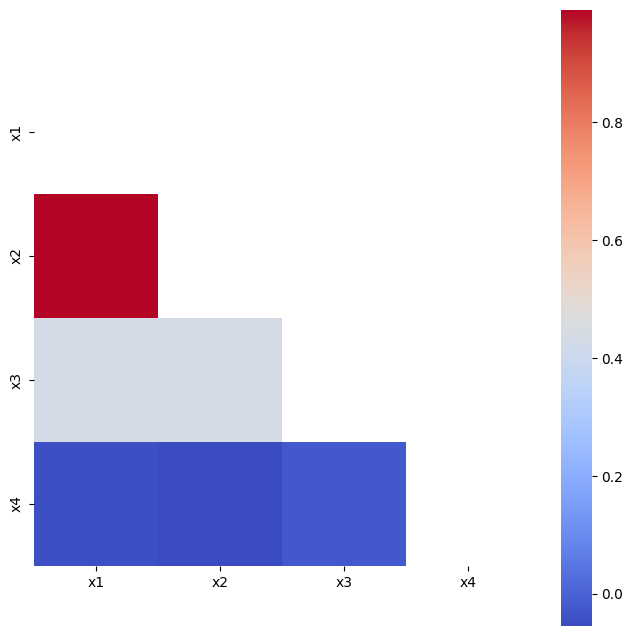

In [22]:
# Initialization
fig, ax = plt.subplots(figsize = (8,8))

df_cor = df_X.corr()
matrix = np.triu(df_cor)
sns.heatmap(df_cor, square=True, cmap= 'coolwarm', mask = matrix);

Now, we do the same for the principal components. And, are the principal
components correlated?

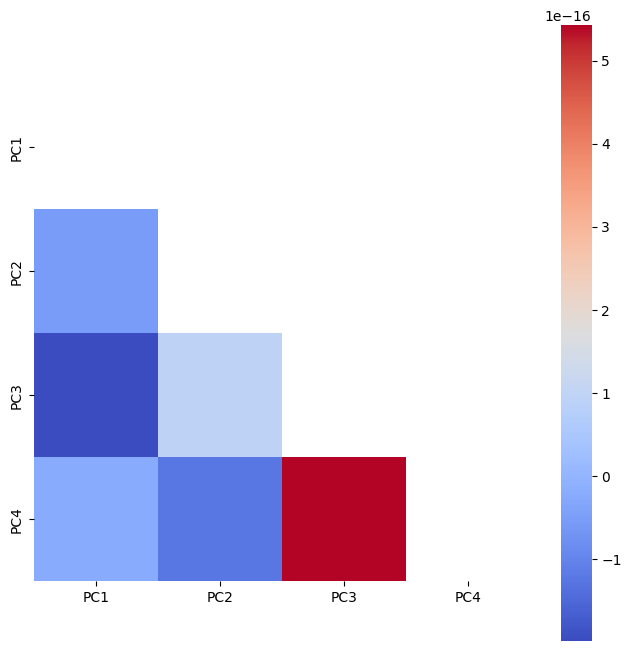

In [24]:
# Initialization
fig, ax = plt.subplots(figsize = (8,8))

df_cor = df_pc.drop(['label'], axis=1).corr()
matrix = np.triu(df_cor)
sns.heatmap(df_cor, square=True, cmap= 'coolwarm', mask = matrix);

And by looking at the numbers…

In [ ]:
#df_pc.drop(['label'], axis=1).corr()

Well done! You reached the end of ML explainer on PCA!
